# День четвертый - нейросети (изображения, тексты, многомерные ряды)

Программа дня:
- нейронные сети с помощью библиотеки `keras`, устройство нейросетей,
- сети, которые выдают свой вход и зачем они нужны - автоэнкодеры,
- элементы работы с изображениями: классификация, сегментация
- предобученные сети работы с изображениями,
- тексты: кодирование, поиск "по смыслу", извлечение сущностей, суммаризация,
- многомерные временные ряды (и рекуррентные нейронные сети).

## 4.1 Нейронные сети на `keras`

В конце второго дня мы рассмотрели некоторый пример нейронных сетей. Все слои там были одинаковые по устройству, и каждый нейрон слоя был связан с каждым нейроном следующего. Такие сети и слои называют *полносвязными* (*Dense*), и это только один из типов слоёв. Ввиду количества связей, полносвязные сети содержат просто огромное количество параметров, из-за этого они долго учатся и дают не самую минимальную ошибку (на не очень большом количестве данных).

Помните, для градиентного спуска мы искали производную по каждому параметру? То же делает и библиотека `tensorflow` (от Google), только она дифференцирует по параметрам автоматически вместо нас (благодаря особой математике на графах операций). `keras` - это надстройка над библиотекой `tensorflow`, позволяющая конструировать различные нейросети, и искать с заданной функцией ошибки её минимум.

Библиотека `scikit-learn` в отличие от `keras`, работает только с полносвязными сетями, и не позволяет произвольно настраивать эту функцию ошибки. **Функция ошибкия является спецификацией задачи нейросети** - это означает что архитектурно одна и та же сеть может может подстраивать свои параметры под разные задачи. 

Помимо упомянутого `Dense`-слоя, существуют следующие слои:
1. Свёрточные (`Convolution`) - применяются обычно для обработки изображений. Они пробегают некоторым окном по всем входным признакам, и вычисляют *свертку* - некоторую функцию с весами сразу над несколькими признаками. Это мало того что позволяет сократить количество весов, но и конструировать новые (внутри сети) признаки.
2. Pooling (`Pooling`, обычно не переводят) - применение операции усреднения или взятия максимума над входными в слой признаками. Используются для снижения размерности сети и извлечения полезных признаков.
3. Рекуррентные (`Recurrent`) - применяются для работы с последовательностями (тексты, временные ряды). Таким слоям на вход подаются последовательности, а они подстраивают свои веса с учетом структуры (если она есть конечно) последовательности.
4. Dropout (`Dropout`, обычно не переводят) - это особый слой, который... выбрасывает случайно заданный процент нейронов между слоями. Это позволяет *регуляризовывать* сеть (избегать переобучения), а так же делает все нейроны сети более "осведомленными", скажем так.
5. Слои вложений (`Embeddings`) - полезны для работы с категориальными данными. Это так же и тексты (со словами из словаря). Такие слои представляют собой таблицу весов, которые переводят входные категории в вектора заданной размерности.

Слои могут (и должны) использовать функцию активации: после умножения весов на вход и сложения, для нейрона полносвязного слоя например, она применяется к результату, чтобы не получить комбинацию линейных моделей (а получить комбинацию нелинейных). Комбинация линейных моделей - линейная модель. Мы уже рассматривали во втором дне `relu`, `tanh`, `sigmoid` (`logistic` в `scikit-learn`). 

Как видим, различные слои подходят под различные задачи.

In [1]:
%matplotlib inline

import os

# будем учить сети на CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # 0 для GPU

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings

import tensorflow.keras as keras
keras.__version__

'2.3.0-tf'

Рассмотрим теперь новый датасет - Forest Cover Types - покрытие лесов. Он содержит 54 признака лесного покрытия, и метку - один из 7 типов леса. Всего в нём 581 012 записей, каждая из которых имеет свой класс (лесного покрытия). Среди признаков: тип почвы, высота над уровнем моря, и другие подобные признаки.

![Forest](media/forest_covtypes.jpg)

In [2]:
from sklearn.utils import shuffle
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(return_X_y=True)

train = int(len(y) * 0.8)
indices = shuffle(list(range(len(y))), random_state=1)
train_indices = indices[:train]
test_indices = indices[train:]

print("Размер всех данных %d, тренировочных %d" % (len(y), train))

Размер всех данных 581012, тренировочных 464809


Раз у нас задача классификации, и классов более двух, наша сеть нам должна отдавать вектор (вероятностей), где индекс наибольшего числа будет указывать на предсказанный класс. Делается это с помощью функции `softmax(x1, ..., xk) = (e(x1) / sum(e(xj)), ..., e(xk) / sum(e(xj))), j = 1..k`

In [3]:
def create_model(number_features, number_classes):
    model = keras.Sequential([
        keras.layers.Dense(units=256, activation='relu', input_shape=(number_features,)),
        
        # пятую часть нейронов при тренировке будем занулять
        keras.layers.Dropout(0.2),
        
        # промежуточный слой
        keras.layers.Dense(32, activation='relu'),
        
        # выходной слой
        keras.layers.Dense(number_classes, activation='softmax')
    ])
    
    # мы должны специфицировать задачу сети
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X[train_indices])

X_train = scaler.transform(X[train_indices])
X_test = scaler.transform(X[test_indices])

# мы должны привести наши классы к векторам вида (0, 1, 0) 
# где 1 стоит на том месте, где должен быть нужный пол
y_categorical = keras.utils.to_categorical(y)

y_train = y_categorical[train_indices]
y_test = y_categorical[test_indices]

# перед созданием модели сбросим
# уже сохраненные модели
keras.backend.clear_session()

model = create_model(
    number_features=X_train.shape[1],
    number_classes=y_train.shape[1]
)

Что мы задали в `compile`? 

- `optimizer` - это способ поиска минимума функции ошибки. Существуют различные оптимизаторы, самые используемые: `rmsprop` (обычно для рекуррентных сетей), `sgd` (когда данных очень много), `adam` (один из самых лучших). Они как раз принимают решение, куда шагать с помощью вычисленной производной ошибки,
- `loss` - это как раз функция ошибки. Для бинарной классификации используют на последнем слое активацию `sigmoid` и `loss = 'binary_crossentropy`, у нас многоклассовая классификация - поэтому `categorical_crossentropy`. Кросс-энтропия тем ниже, чем меньше перепутаны предсказанные и истинные метки. Для регрессии же используют функции потерь `mae` (*mean_absolute_error*) или `mse` (*mean_squared_error*) - которые являются средним (абсолютным или квадратичным) отклонением предсказанного от известных значений,
- `metrics` - это то, что в процессе обучение будет подсчитываться просто для информации или для отбора лучшей модели. В нашем случае `accuracy` - это процент правильных ответов.

Ну что ж, обучим нашу нейросеть. При обучении мы зададим *количество эпох* и *размер пакета* (*batch size*). Одна эпоха - это один проход по всем тренировочным данным с выборкой размера пакета (то есть шагом в размер пакета). На каждый пакет подсчитываются (те самые) производные по параметрам для каждого пакета и обновляются веса нейросети.

In [4]:
model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=30,
    verbose=1 # выводить информацию по ходу дела
);

Epoch 1/30
454/454 [==============================] - 2s 5ms/step - loss: 0.6820 - accuracy: 0.7185
Epoch 2/30
454/454 [==============================] - 2s 5ms/step - loss: 0.5580 - accuracy: 0.7600
Epoch 3/30
454/454 [==============================] - 2s 5ms/step - loss: 0.5174 - accuracy: 0.7776
Epoch 4/30
454/454 [==============================] - 2s 5ms/step - loss: 0.4884 - accuracy: 0.7919
Epoch 5/30
454/454 [==============================] - 2s 5ms/step - loss: 0.4678 - accuracy: 0.8016
Epoch 6/30
454/454 [==============================] - 2s 5ms/step - loss: 0.4519 - accuracy: 0.8088
Epoch 7/30
454/454 [==============================] - 2s 5ms/step - loss: 0.4383 - accuracy: 0.8152
Epoch 8/30
454/454 [==============================] - 2s 5ms/step - loss: 0.4274 - accuracy: 0.8202
Epoch 9/30
454/454 [==============================] - 2s 5ms/step - loss: 0.4188 - accuracy: 0.8235
Epoch 10/30
454/454 [==============================] - 2s 5ms/step - loss: 0.4100 - accuracy: 0.8282

In [5]:
'loss %.2f, accuracy %.2f' % tuple(model.evaluate(X_test, y_test))

3632/3632 [==============================] - 3s 767us/step - loss: 0.3011 - accuracy: 0.8785


'loss 0.30, accuracy 0.88'

Поскольку метрика качества продолжает расти, скорее всего мы задали мало итераций. Однако сети имеют свойство переобучаться, поэтому и используется и `dropout`, и отбор лучшей модели по метрикам. Для последнего, используется `callback` (функция, вызываемая на каждой эпохе) `ModelCheckpoint`. Как его использовать, наряду со своим ~~доморощенным~~, показано в коде ниже.

In [6]:
from IPython.display import clear_output

# отнаследуемся от базового класса и переопределим конструктор
# и метод, вызываемый по окончанию эпохи

class PlotLosses(keras.callbacks.Callback):
    def __init__(self, metric=False, check_max=True):
        super(PlotLosses, self).__init__()
        self.logs = []
        self.losses = []
        self.val_losses = []
        self.metric = metric or 'loss'
        self.better = max if check_max else min
        
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        self.logs.append(logs)
        x = range(1, len(self.logs) + 1)

        self.losses.append(logs.get(self.metric))
        if logs.get('val_' + self.metric):
            self.val_losses.append(logs.get('val_' + self.metric))
        
        if len(self.val_losses):
            self.best_step = 1 + (
                self.val_losses.index(self.better(self.val_losses)) or 0
            )
        else:
            self.best_step = epoch

        plt.plot(x, self.losses, ls='--', c='#323232', label=self.metric)
        if len(self.val_losses):
            plt.plot(x, self.val_losses, ls='-', c='#323232', label="val_" + self.metric)
        plt.title("Step %d, %.4f" % (
            len(self.logs),
            logs.get(self.metric) or 0
        ) + (", validation %.4f (best %.4f at %d)" % (
            logs.get('val_' + self.metric) or 0,
            self.better(self.val_losses if len(self.val_losses) else [0]) or 0,
            self.best_step
        ) if logs.get('val_' + self.metric) else ''))
        plt.legend(loc='best')        
        plt.show()

Для отбора лучшей модели используют валидационное множество (а итоговое качество всё так же проверяют на тестовом). 

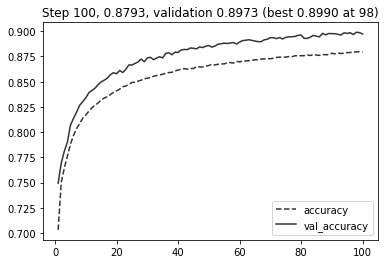

In [7]:
keras.backend.clear_session()

model = create_model(
    number_features=X_train.shape[1],
    number_classes=y_train.shape[1]
)

# четверть тренировочных оставим
# под валидацию
validation = int(train * 0.25)

model.fit(
    X_train[validation:], y_train[validation:],
    batch_size=1024,
    epochs=100,
    validation_data=(X_train[:validation], y_train[:validation]),
    verbose=0, # НЕ выводить информацию по ходу дела
    callbacks=[
        PlotLosses(metric='accuracy'),
        keras.callbacks.ModelCheckpoint(
            'models/covtypes.h5',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]
);

In [8]:
# загрузим нашу лучшую отобранную по accuracy на валидации модель
best_model = keras.models.load_model('models/covtypes.h5')
'loss %.2f, accuracy %.2f' % tuple(best_model.evaluate(X_test, y_test))

3632/3632 [==============================] - 3s 782us/step - loss: 0.2579 - accuracy: 0.8974


'loss 0.26, accuracy 0.90'

## Заключение

Видим, что метрика и дальше могла бы улучшаться, но с каждым шагом дальше это происходит всё медленнее, улучшение всё меньше. На диаграммах, подобных выше, сразу видно, переобучается модель (на тренировочных данных метрика сильно больше) или нет (тренировочные и валидационные данные дают схожие метрики).

Так же стоит отметить, что готовить данные для сетей и обучать их - дело не самое простое. Тем не менее, их "всеядность" в плане данных не оставляет иного выбора исследователям. И далее мы посмотрим, что еще могут такого нейросети, кроме и так нам понятных табличных данных.

## 4.2 Автоэнкодеры

Автоэнкодеры - это сети, которые для своих входов на выходе выдают этот же вход. Стараются по-крайней мере :) Давайте сразу начнем с примера, и примера повеселее - датасета `fashion mnist`, который содержит 60 тысяч тренировочных примеров, и 10 тысяч тестовых примеров изображений одежды размеров 28х28 пикселей в градациях серого (0 черный, 1 белый), разбитых по 10 классам (различные ботинки, брюки, свитера-майки).

In [9]:
import mnist
train_X, train_y, test_X, test_y = mnist.fashion_mnist()
fashion = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

[MNIST] Caching data at C:\Users\Sazonov_AV\.local\share\FASHION_MNIST
[MNIST] Found http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz in cache.
[MNIST] Found http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz in cache.
[MNIST] Found http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz in cache.
[MNIST] Found http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz in cache.


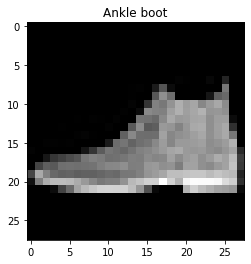

In [10]:
plt.title(fashion[test_y[0]]);
plt.imshow(test_X[0], cmap='gray');

Построим сразу сверточную нейросеть, которая будет сворачивать изображение до вектора, а потом разворачивать в изображение обратно.

In [58]:
keras.backend.clear_session()

def create_autoencoder(shape, vector_size=3):
    input_layer = layer = keras.layers.Input(shape)
    
    filters = 16
    
    layer = keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(layer)
    # после этого у нас размерность данных 28 * 28 * filters
        
    # возьмем максимум из получаемых данных максимум,
    # padding same - означает дополнять изображение значениям краёв, когда окно выходит за его пределы
    layer = keras.layers.MaxPool2D((2, 2), padding='same')(layer)
    # после этого у нас размерность 14 * 14 * filters
    
    # свернем всё в вектор
    layer = keras.layers.Flatten()(layer)
    
    encoded = keras.layers.Dense(vector_size, activation='relu')(layer)
    
    encoder = keras.Model(input_layer, encoded, name='encoder')    
    
    # вернем всё обратно
    decoder_input = keras.layers.Input((vector_size, ))
    
    layer = keras.layers.Dense(14 * 14 * filters, activation='relu')(decoder_input)
    layer = keras.layers.Reshape((14, 14, filters))(layer)

    layer = keras.layers.UpSampling2D((2, 2))(layer)

    # реконструируем наше изображение
    # будем выдавать степень "белизны"
    output_layer = keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(layer)
    
    decoder = keras.Model(decoder_input, output_layer, name='decoder')
    
    model = keras.Model(input_layer, decoder(encoder(input_layer)))
    model.compile('adam', 'mae')
    
    return model, encoder, decoder

autoencoder, encoder, decoder = create_autoencoder((28, 28, 1)) # 1 - это у нас один черно-белый канал
print(encoder.summary())
print(decoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 9411      
Total params: 9,571
Trainable params: 9,571
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output

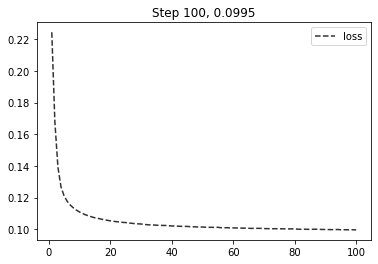

In [59]:
# в датасете градации серого от 0 до 255
training_set = np.expand_dims(train_X, axis=-1) / 255.

# будем обучать только на пятой части датасета - для скорости
# поскольку у нас классификация - сделаем стратифицированный сплит
from sklearn.model_selection import train_test_split

train_subset_X, train_subset_y, _, _ = train_test_split(
    training_set, train_y, random_state=1, test_size=0.8
)

autoencoder.fit(
    train_subset_X,
    train_subset_X, # да, здесь y = X, так как это AutoEncoder
    epochs=100,
    batch_size=len(train_subset_X) // 30, # большой пакет, 400
    verbose=0,
    callbacks=[PlotLosses()]
);

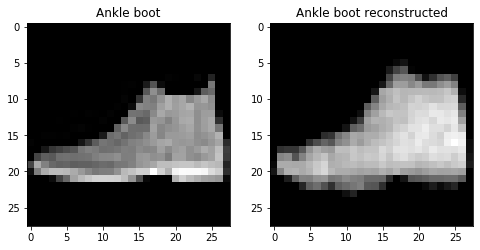

In [60]:
figure, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title(fashion[test_y[0]]);
axes[0].imshow(test_X[0], cmap='gray');

axes[1].set_title(fashion[test_y[0]] + ' reconstructed');
axes[1].imshow(
    autoencoder.predict(
        test_X[0].reshape(1, 28, 28, 1) / 255.
    )[0].reshape(28, 28),
    cmap='gray'
);

Замечательно (хотя и не очень), мы обучили автоэнкодер. Автоэнкодеры сами по себе не очень полезны, разве что в случае чистки изображений от шумов (для этого на вход при обучении подают зашумленные изображения, а как выход - чистые). Но и без этого попробуем. 

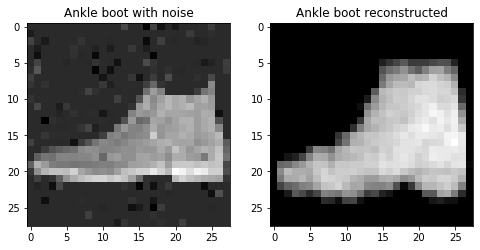

In [61]:
figure, axes = plt.subplots(1, 2, figsize=(8, 4))

np.random.seed(1)

noised_sample = (test_X[0] / 255.).copy()
for height in range(noised_sample.shape[0]):
    for width in range(noised_sample.shape[1]):
        if np.random.uniform() > 0.8:
            noised_sample[height, width] += np.random.normal(0, 0.1)

axes[0].set_title(fashion[test_y[0]] + ' with noise');
axes[0].imshow(noised_sample, cmap='gray');

axes[1].set_title(fashion[test_y[0]] + ' reconstructed');
axes[1].imshow(
    autoencoder.predict(
        noised_sample.reshape(1, 28, 28, 1)
    )[0].reshape(28, 28),
    cmap='gray'
);

Но они более полезны тем, что у нас есть трехмерное представление каждого изображения!

In [62]:
encoder.predict(noised_sample.reshape(1, 28, 28, 1))[0].tolist()

[12.543291091918945, 0.0, 4.068973064422607]

Давайте посмотрим, что представляют собой полученные вектора на тестовом множестве, и сразу отобразим метки классов.

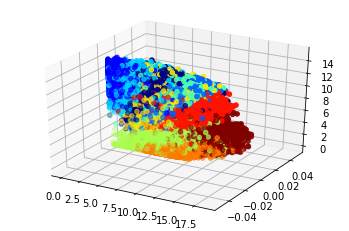

In [63]:
from mpl_toolkits.mplot3d import Axes3D
axes = plt.subplot(projection='3d')

test_vectors = encoder.predict(test_X.reshape(-1, 28, 28, 1) / 255.)
axes.scatter(
    test_vectors[:, 0],
    test_vectors[:, 1],
    test_vectors[:, 2],
    c=test_y,
    cmap='jet'
);

Вот по таким у нас получилось "полочкам" всё разложилось.

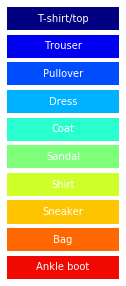

In [64]:
from matplotlib.patches import Rectangle
figure, axis = plt.subplots(10, 1, figsize=(2, 5))
for color in range(10):
    axis[color].add_patch(Rectangle((0, 0), 1, 2, alpha=1, facecolor=plt.get_cmap('jet')(color / 10)))
    axis[color].axis('off')
    axis[color].annotate(fashion[color], (0.5, 0.5), c='white', ha='center', va='center')
plt.show()

Дальше можно либо кластеризовывать, либо строить классификатор. Попробуем и кластеризацию (тестового множества), и классификацию.

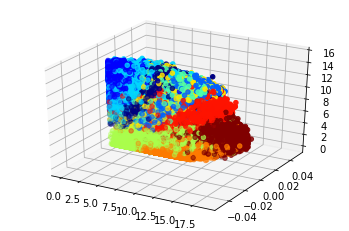

In [65]:
train_vectors = encoder.predict(train_X.reshape(-1, 28, 28, 1) / 255.)

axes = plt.subplot(projection='3d')
axes.scatter(
    train_vectors[:, 0],
    train_vectors[:, 1],
    train_vectors[:, 2],
    c=train_y,
    cmap='jet'
);

In [66]:
from hdbscan import HDBSCAN # библиотека быстрой кластеризации
from sklearn.metrics import silhouette_score

best_score = -np.inf
best_number = 1
best_size = 0

for min_size in [50, 100, 200]:
    clusterer = HDBSCAN(min_cluster_size=min_size).fit(test_vectors)
    if len(pd.unique(clusterer.labels_)) < 2:
        continue
    score = silhouette_score(test_vectors, clusterer.labels_)
    if score > best_score:
        best_score = score
        best_size = min_size
        best_number = len(pd.unique(clusterer.labels_))

'best clusters number %d with min cluster size = %d and score %.2f' % (best_number, best_size, best_score)

'best clusters number 3 with min cluster size = 50 and score 0.36'

Как видим, разложилось всё как-то не по 10 полочкам. Ладно...

In [67]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=1, max_iter=1000).fit(train_vectors, train_y)
"%.2f" % classifier.score(test_vectors, test_y)

'0.61'

Ради интереса, я скачал первые две попавшиеся картинки с wildberries (не реклама!), и обрезал их как можно ближе к квадрату.

![Test1](media/test_1_square.jpg)

> Квадратные штаны не получились

![Test2](media/test_2_square.jpg)

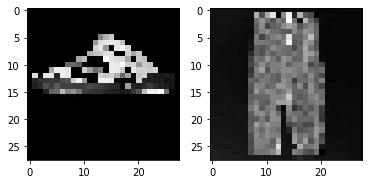

In [72]:
# скормим их нашему классификатору!

from PIL import Image

test_1 = Image.open('media/test_1_square.jpg').convert('L') # grayscale
test_1 = 1. - np.array(test_1.resize((28, 28))) / 255.

test_2 = Image.open('media/test_2_square.jpg').convert('L')
test_2 = 1. - np.array(test_2.resize((28, 28))) / 255.

plt.subplot(1, 2, 1)
plt.imshow(test_1, cmap='gray');
plt.subplot(1, 2, 2)
plt.imshow(test_2, cmap='gray');

In [73]:
fashion[
    classifier.predict(
        encoder.predict(test_1.reshape(1, 28, 28, 1))
    )[0]
], fashion[
    classifier.predict(
        encoder.predict(test_2.reshape(1, 28, 28, 1))
    )[0]
]

('Sandal', 'Shirt')

С сандалями разобрались, а вот штаны оказались футболкой. Что ж, такие вот на wildberries штаны (хотя на самом деле они не по центру фото). Я скачал еще классические мужские брюки и отцентрировал их.

![Test 3](media/test_3.jpg)

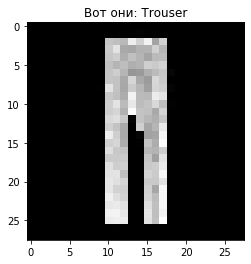

In [100]:
test_3 = Image.open('media/test_3.jpg').convert('L')
test_3 = 1. - np.array(test_3.resize((28, 28))) / 255.

plt.title("Вот они: " + fashion[
    classifier.predict(
        encoder.predict(test_3.reshape(1, 28, 28, 1))
    )[0]
])
plt.imshow(test_3, cmap='gray');

## Заключение

Если поучить подольше, то изображения кучковались бы еще лучше - автоэнкодер бы их сильнее различал. Соответственно и вектора различались бы сильнее. Главное, что векторное представление дает нам некоторое скрытое (*латентное*) пространство векторов, с которыми уже можно работать. И да, чем больше размерность вектора скрытого пространства, тем лучше, для отображения вложений лучше использовать `UMAP`.